In [419]:
# from google.colab import drive
# drive.mount('/content/drive')

In [420]:
# %pip -q install gtbook # also installs latest gtsam pre-release


In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math
import glob
import gtsam
import gtsam.utils.plot
import os
import itertools

In [26]:
### Use this code to load images from local memory.


def ReadImage(ImageFolderPath):
    Images = []
    if os.path.isdir(ImageFolderPath):
        ImageNames = os.listdir(ImageFolderPath)
        ImageNames_Split = [[int(os.path.splitext(os.path.basename(ImageName))[0]), ImageName] for ImageName in ImageNames]
        ImageNames_Split = sorted(ImageNames_Split, key=lambda x:x[0])
        ImageNames_Sorted = [ImageNames_Split[i][1] for i in range(len(ImageNames_Split))]
        for i in range(len(ImageNames_Sorted)):
            ImageName = ImageNames_Sorted[i]
            InputImage = cv2.imread(ImageFolderPath + "/" + ImageName) 
            if InputImage is None:
                print("Not able to read image: {}".format(ImageName))
                exit(0)
            Images.append(InputImage)   
    return Images
imgs6 = ReadImage("C:/Users/ROHIT/Downloads/eece7150/HW3/6Images/img/")
print(len(imgs6))

6


In [27]:
### Use this code for Google Colab

# imgs6 = []
# path = "/content/drive/MyDrive/Colab Notebooks/6Images/6Images/img/"
# files = sorted(filter(os.path.isfile, glob.glob(path + '*')))
# for img in files:
#   imgs6.append(cv2.imread(img))

# print(len(imgs6))

In [25]:
# directories = [
#     '/content/drive/MyDrive/Colab Notebooks/6Images/6Images/29img/first column/',
#     '/content/drive/MyDrive/Colab Notebooks/6Images/6Images/29img/second column/',
#     '/content/drive/MyDrive/Colab Notebooks/6Images/6Images/29img/third column/',
#     '/content/drive/MyDrive/Colab Notebooks/6Images/6Images/29img/fourth column/'
# ]

# AllImages = []
# for path in directories:
#     files = sorted(filter(os.path.isfile, glob.glob(path + '*')))
#     for img in files:
#         AllImages.append(cv2.imread(img))
AllImages = imgs6
print(len(AllImages))

6


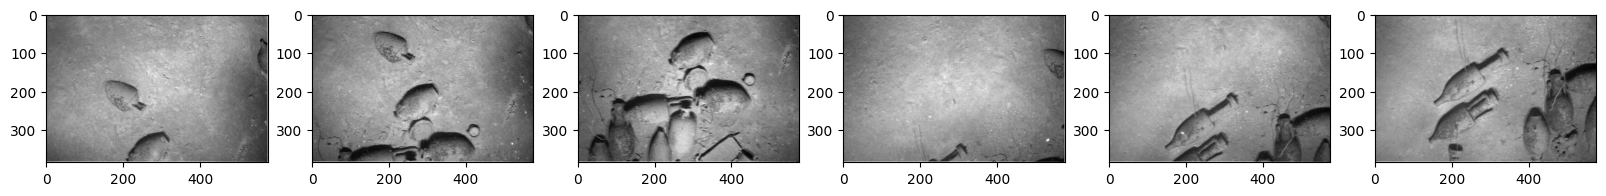

In [424]:
fig = plt.figure(figsize=(20,20))
i=1
for image in range(len(AllImages)):
    fig.add_subplot(1, len(AllImages), i)
    plt.imshow(AllImages[image])
    i+=1

In [425]:
def FindMatches(Image1, Image2, flag = False):
  if flag == False:
      Sift = cv2.SIFT_create()
      Image1Keypoints, Image1Descriptors = Sift.detectAndCompute(cv2.cvtColor(Image1, cv2.COLOR_BGR2GRAY), None)
      Image2Keypoints, Image2Descriptors = Sift.detectAndCompute(cv2.cvtColor(Image2, cv2.COLOR_BGR2GRAY), None)

      BF_Matcher = cv2.BFMatcher()
      InitialMatches = BF_Matcher.knnMatch(Image1Descriptors, Image2Descriptors, k=2)

      GoodMatches = []
      for m, n in InitialMatches:
          if m.distance < 0.75 * n.distance:
              GoodMatches.append([m])
      img3 = cv2.drawMatchesKnn(Image1,Image1Keypoints,Image2,Image2Keypoints,GoodMatches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
      plt.imshow(img3),plt.show()
      return GoodMatches, Image1Keypoints, Image2Keypoints
  elif flag == True:
    keypoints = Image1
    descriptors = Image2
    matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    keypoint_matches = []
    matches = []

    for i in range(len(keypoints)):
        descriptors1 = descriptors[i]
        if i < len(keypoints) - 1:
            descriptors2 = descriptors[i + 1]
        else:
            descriptors2 = descriptors[0]

        knn = matcher.knnMatch(descriptors2, descriptors1, k=2)

        filtered_matches = []
        mask = np.zeros((descriptors1.shape[0], descriptors2.shape[0]), dtype='uint8')

        for match in knn:
            if len(match) == 1 or (len(match) > 1 and match[0].distance < 0.90 * match[1].distance):
                filtered_matches.append(match[0])
                mask[match[0].trainIdx, match[0].queryIdx] = 1
        matches2 = matcher.match(descriptors1, descriptors2, mask=mask)
        matches.append(matches2)
        keypoint0Matches = np.array([keypoints[i][mat.queryIdx].pt for mat in matches2])

        if i < len(keypoints) - 1:
            keypoint1Matches = np.array([keypoints[i+1][mat.trainIdx].pt for mat in matches2])
        else:
            keypoint1Matches = np.array([keypoints[0][mat.trainIdx].pt for mat in matches2])

        keypoint_matches.append((keypoint0Matches, keypoint1Matches))

    return matches, keypoint_matches

def Homography(keypoints=[],Matches=[], BaseImage_kp=[], SecImage_kp=[],flag=True):
  if flag == True:
    if len(Matches) < 4:
      print("\nNot enough matches found between the images.\n")
      exit(0)

    Image1Points = []
    Image2Points = []
    for Match in Matches:
      Image1Points.append(BaseImage_kp[Match[0].queryIdx].pt)
      Image2Points.append(SecImage_kp[Match[0].trainIdx].pt)

    Image1Points = np.float32(Image1Points)
    Image2Points = np.float32(Image2Points)

    (HomographyMatrix, Status) = cv2.findHomography(Image2Points, Image1Points, cv2.RANSAC, 4.0)

    return HomographyMatrix, Status
  if flag == False:
    global img1pts, img2pts
    img1pts = []
    img2pts = []
    for matches in keypoints:
      img1pts.append(np.float32([matches[0][i] for i in range(len(matches[0]))]))
      img2pts.append(np.float32([matches[1][i] for i in range(len(matches[1]))]))

    h = []
    status = []
    for i in range(len(img1pts)):
      temp_h, temp_mask = cv2.findHomography(img2pts[i],img1pts[i],cv2.RANSAC,1.0)
      h.append(temp_h)
      status.append(temp_mask)
    return h, status

def Canvas(HomographyMatrix, Sec_ImageShape, Base_ImageShape):
    (Height, Width) = Sec_ImageShape
    InitialMatrix = np.array([[0, Width - 1, Width - 1, 0], [0, 0, Height - 1, Height - 1], [1, 1, 1, 1]])
    FinalMatrix = np.dot(HomographyMatrix, InitialMatrix)
    [x, y, c] = FinalMatrix
    x = np.divide(x, c)
    y = np.divide(y, c)
    min_x, max_x = int(round(min(x))), int(round(max(x)))
    min_y, max_y = int(round(min(y))), int(round(max(y)))
    UpdatedWidth = max_x
    UpdatedHeight = max_y
    corr = [0, 0]
    if min_x < 0:
        UpdatedWidth -= min_x
        corr[0] = abs(min_x)
    if min_y < 0:
        UpdatedHeight -= min_y
        corr[1] = abs(min_y)
    if UpdatedWidth < Base_ImageShape[1] + corr[0]:
        UpdatedWidth = Base_ImageShape[1] + corr[0]
    if UpdatedHeight < Base_ImageShape[0] + corr[1]:
        UpdatedHeight = Base_ImageShape[0] + corr[1]
    x = np.add(x, corr[0])
    y = np.add(y, corr[1])
    InitialPoints = np.float32([[0, 0], [Width - 1, 0], [Width - 1, Height - 1], [0, Height - 1]])
    FinalPonts = np.float32(np.array([x, y]).transpose())
    HomographyMatrix = cv2.getPerspectiveTransform(InitialPoints, FinalPonts)

    return [UpdatedHeight, UpdatedWidth], corr, HomographyMatrix



def StitchImages(BaseImage, SecImage):
    SecImage_Cyl, mask_x, mask_y = MakeTransformations(SecImage)
    SecImage_Mask = np.zeros(SecImage_Cyl.shape, dtype=np.uint8)
    SecImage_Mask[mask_y, mask_x, :] = 255
    Matches, BaseImage_kp, SecImage_kp = FindMatches(BaseImage, SecImage_Cyl)
    HomographyMatrix, Status = Homography(Matches=Matches, BaseImage_kp=BaseImage_kp, SecImage_kp=SecImage_kp)
    NewFrameSize, Correction, HomographyMatrix = Canvas(HomographyMatrix, SecImage_Cyl.shape[:2], BaseImage.shape[:2])
    SecImage_Transformed = cv2.warpPerspective(SecImage_Cyl, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    SecImage_Transformed_Mask = cv2.warpPerspective(SecImage_Mask, HomographyMatrix, (NewFrameSize[1], NewFrameSize[0]))
    BaseImage_Transformed = np.zeros((NewFrameSize[0], NewFrameSize[1], 3), dtype=np.uint8)
    BaseImage_Transformed[Correction[1]:Correction[1]+BaseImage.shape[0], Correction[0]:Correction[0]+BaseImage.shape[1]] = BaseImage
    StitchedImage = cv2.bitwise_or(SecImage_Transformed, cv2.bitwise_and(BaseImage_Transformed, cv2.bitwise_not(SecImage_Transformed_Mask)))
    return StitchedImage


def MakeTransformations(Image1):
    global width, height, center, f
    height, width = Image1.shape[:2]
    center = [width // 2, height // 2]
    f = 1100
    TransformedImage = np.zeros(Image1.shape, dtype=np.uint8)
    ti =  np.array([np.array([i, j]) for i in range(width) for j in range(height)])
    ti_x = ti[:, 0]
    ti_y = ti[:, 1]
    ii_x = ( f * np.tan( (ti_x - center[0]) / f ) ) + center[0]
    ii_y = ( (ti_y - center[1]) / np.cos( (ti_x - center[0]) / f ) ) + center[1]
    ii_tl_x = ii_x.astype(int)
    ii_tl_y = ii_y.astype(int)
    gg = (ii_tl_x >= 0) * (ii_tl_x <= (width-2)) * (ii_tl_y >= 0) * (ii_tl_y <= (height-2))
    ti_x = ti_x[gg]
    ti_y = ti_y[gg]
    ii_x = ii_x[gg]
    ii_y = ii_y[gg]
    ii_tl_x = ii_tl_x[gg]
    ii_tl_y = ii_tl_y[gg]
    dx = ii_x - ii_tl_x
    dy = ii_y - ii_tl_y
    weight_tl = (1.0 - dx) * (1.0 - dy)
    weight_tr = (dx)       * (1.0 - dy)
    weight_bl = (1.0 - dx) * (dy)
    weight_br = (dx)       * (dy)
    TransformedImage[ti_y, ti_x, :] = ( weight_tl[:, None] * Image1[ii_tl_y, ii_tl_x] ) + ( weight_tr[:, None] * Image1[ii_tl_y, ii_tl_x + 1] ) + ( weight_bl[:, None] * Image1[ii_tl_y + 1, ii_tl_x] ) + ( weight_br[:, None] * Image1[ii_tl_y + 1, ii_tl_x + 1] )
    min_x = min(ti_x)
    TransformedImage = TransformedImage[:, min_x : -min_x, :]
    return TransformedImage, ti_x-min_x, ti_y

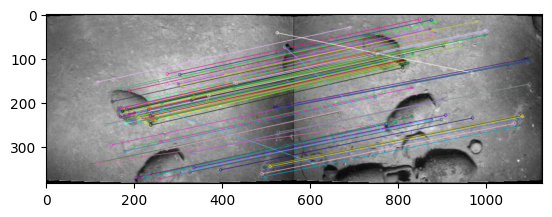

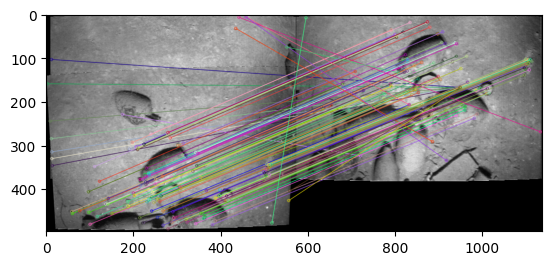

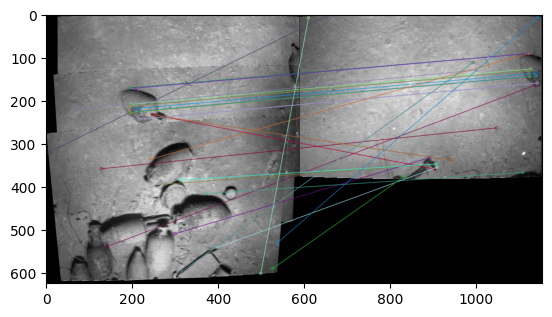

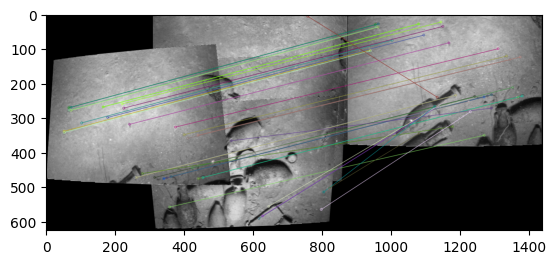

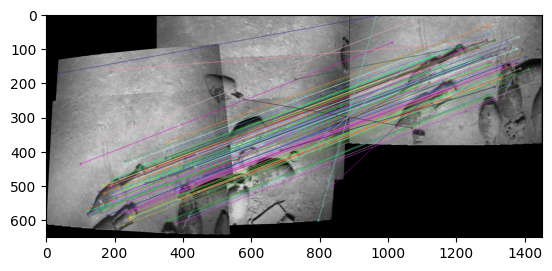

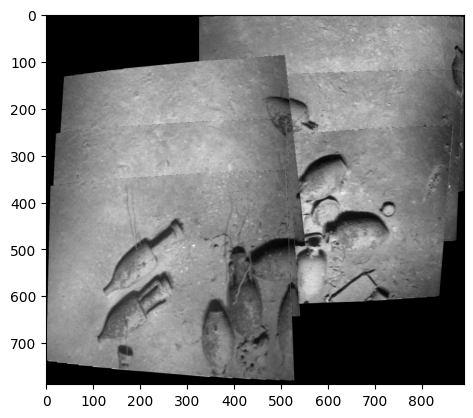

In [426]:
Images = AllImages
BaseImage, _, _ = MakeTransformations(Images[0])
for i in range(1, len(Images)):
    StitchedImage = StitchImages(BaseImage, Images[i])

    BaseImage = StitchedImage.copy()
# cv2.imwrite("Stitched_Panorama123.png", BaseImage)
plt.figure()
plt.imshow(BaseImage)

In [427]:
NormalizedImages = [cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX) for img in AllImages]
grayImages = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in NormalizedImages]
im_h, im_w = grayImages[0].shape
sift = cv2.xfeatures2d.SIFT_create(nfeatures=4000, nOctaveLayers=12, contrastThreshold=0.025, sigma=1.6)

In [428]:
keypoints = []
descriptors = []
ImgWithKeypoints = []

for gr in grayImages:
    kpts, descs = sift.detectAndCompute(gr, None)

    bimg = np.zeros((im_h, im_w))
    response = np.array([keypoint.response for keypoint in kpts])
    mask = np.flip(np.argsort(response))
    points = np.rint([keypoint.pt for keypoint in kpts])[mask].astype(int)

    mask_non = []
    for i in range(len(points)):
        pt = points[i]
        if bimg[pt[1], pt[0]] == 0:
            mask_non.append(mask[i])
            cv2.circle(bimg, (pt[0], pt[1]), 2, 255, -1)

    imgWKpts = cv2.drawKeypoints(gr, kpts, gr, color=[0, 255, 0], flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    keypoints.append(np.array(kpts)[mask_non])
    descriptors.append(np.array(descs)[mask_non])
    ImgWithKeypoints.append(imgWKpts)

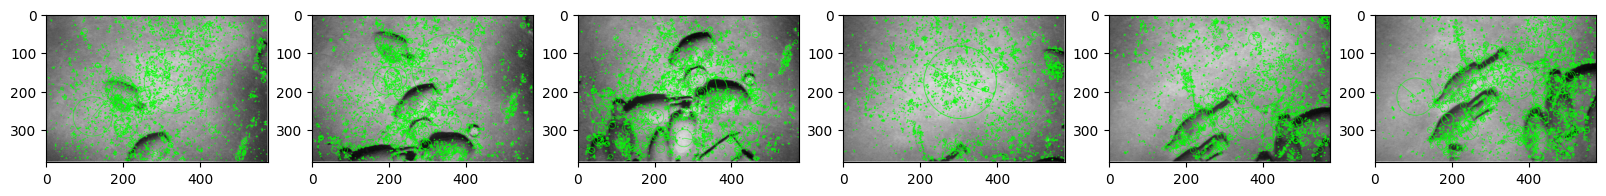

In [429]:
fig = plt.figure(figsize=(20,20))
i=1
for image in range(len(ImgWithKeypoints)):
    fig.add_subplot(1, len(ImgWithKeypoints), i)
    plt.imshow(ImgWithKeypoints[image])
    i+=1

In [430]:
matches, keypoint_matches = FindMatches(keypoints, descriptors,flag = True)

In [431]:
#del
for i in range(len(matches)):
  print(len(matches[i]),len(keypoint_matches[i]))

599 2
595 2
243 2
457 2
615 2
261 2


In [432]:
h, mask = Homography(keypoints=keypoint_matches, flag=False)

In [433]:
translations = [0,0]
for i in range(len(h)-2):
    h[i][0][2] += translations[0]
    h[i][1][2] += translations[1]
    if i != 0:
        h[i] = np.dot(h[i],h[i-1])

In [434]:
def getOdometryNoise(mask): # Curtis Manore's Noise Model
    numMatches = np.count_nonzero(mask)

    error_ranges = {
        "min": (0.1, 0.1, 0.1),
        "small": (0.3, 0.3, 0.25),
        "large": (0.7, 0.7, 0.4),
        "max": (1.0, 1.0, 0.5)
    }

    error_type = "min" if numMatches > 100 else "small" if 50 < numMatches <= 100 else "large" if 20 < numMatches <= 50 else "max"
    error_values = error_ranges.get(error_type, error_ranges["max"])

    return gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(*error_values))

#From GTSAM
PRIOR_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.3, 0.3, 0.1))
# ODOMETRY_NOISE = gtsam.noiseModel.Diagonal.Sigmas(gtsam.Point3(0.2, 0.2, 0.1))
graph = gtsam.NonlinearFactorGraph()
graph.add(gtsam.PriorFactorPose2(0, gtsam.Pose2(0, 0, 0), PRIOR_NOISE))

ransac_mask = []
def getFactorPose(index, pts_src = img1pts, pts_dst = img2pts):

    global ransac_mask
    similarity_mat, ransac_mask = cv2.estimateAffinePartial2D(pts_dst[index],pts_src[index])
    if np.count_nonzero(ransac_mask) > 10:
        scale = np.sqrt(similarity_mat[0, 0]**2+similarity_mat[1, 0]**2)
        similarity_mat[:2, :2] /= scale
        affine_matrix = np.vstack((similarity_mat, [0, 0, 1]))
        return gtsam.Pose2(affine_matrix[0, -1], affine_matrix[1, -1],
                    np.arctan2(affine_matrix[1, 0], affine_matrix[0, 0]))
    return None


In [435]:
initial_estimate = gtsam.Values()
initial_estimate.insert(0, gtsam.Pose2(0, 0, 0))

for i in range(len(h)-1):
    estimate = h[i]
    estimate[2][0], estimate[2][1] = 0,0
    s = np.sqrt(estimate[0,0]**2+estimate[1,0]**2) # adapted from ZZ
    estimate[:2, :2] /= s
    total_affine_matrix = np.eye(3)
    EstimateInv = np.linalg.inv(estimate)
    estimate = EstimateInv.dot(total_affine_matrix)
    x,y, theta = estimate[0,2], estimate[1,2], np.arctan2(estimate[1, 0], estimate[0, 0])
    initial_estimate.insert(i+1, gtsam.Pose2(x,y,theta))


In [436]:
for img1I, img2I in itertools.combinations(range(len(NormalizedImages)), 2):
    if img1I + 1 == img2I:
        print(img1I, end= " ")
        if getFactorPose(img1I) != None:
          graph.add(gtsam.BetweenFactorPose2(img1I, img2I, getFactorPose(img1I), getOdometryNoise(mask[img1I])))
    else:
        Keypoints = [keypoints[img1I],keypoints[img2I]]
        Descriptors = [descriptors[img1I],descriptors[img2I]]
        Matches, KeypointMatches = FindMatches(Keypoints,Descriptors, flag = True)
        H, Mask = Homography(keypoints=KeypointMatches, flag=False)

        img1Points = []
        img2Points = []
        for keypts in KeypointMatches:
            img1Points.append(np.float32([keypts[0][i] for i in range(len(keypts[0]))]))
            img2Points.append(np.float32([keypts[1][i] for i in range(len(keypts[1]))]))
        Pose = getFactorPose(0, img1Points, img2Points)
        if Pose is not None:
            graph.add(gtsam.BetweenFactorPose2(img1I, img2I, Pose, getOdometryNoise(ransac_mask)))

0 1 2 3 4 

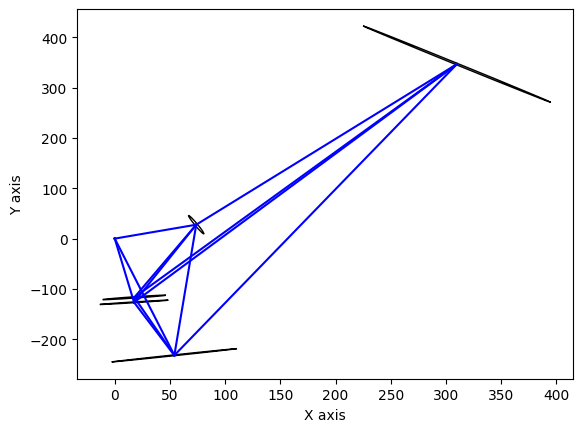

In [437]:
marginals = gtsam.Marginals(graph, initial_estimate)

for i in range(initial_estimate.size()):
    gtsam.utils.plot.plot_pose2(0, initial_estimate.atPose2(i), 0.5, marginals.marginalCovariance(i))

for i in range(graph.size())[1:]:
    k1, k2 = graph.at(i).keys()
    img1Pose = initial_estimate.atPose2(k1)
    img2Pose = initial_estimate.atPose2(k2)
    plt.plot([img1Pose.x(), img2Pose.x()], [img1Pose.y(), img2Pose.y()], color='blue')
plt.show()

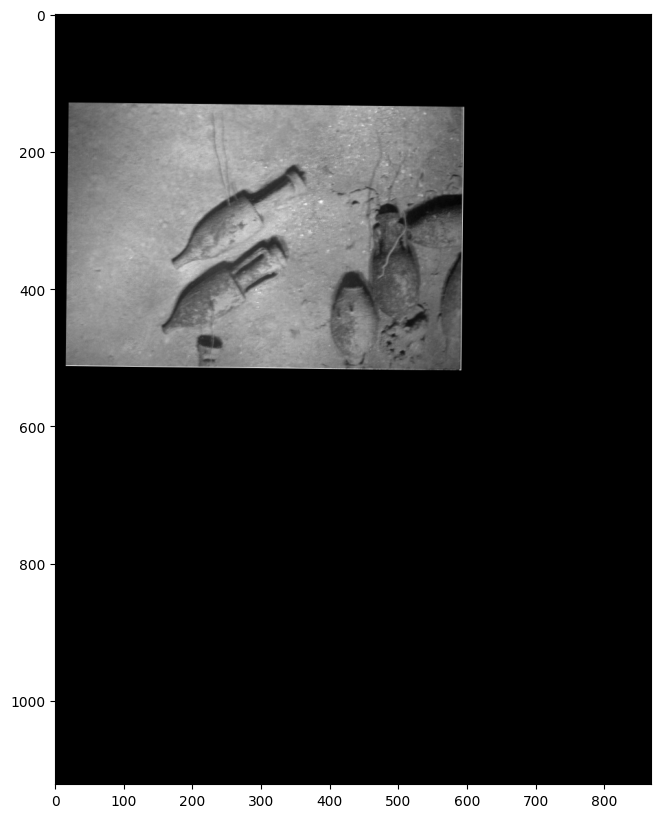

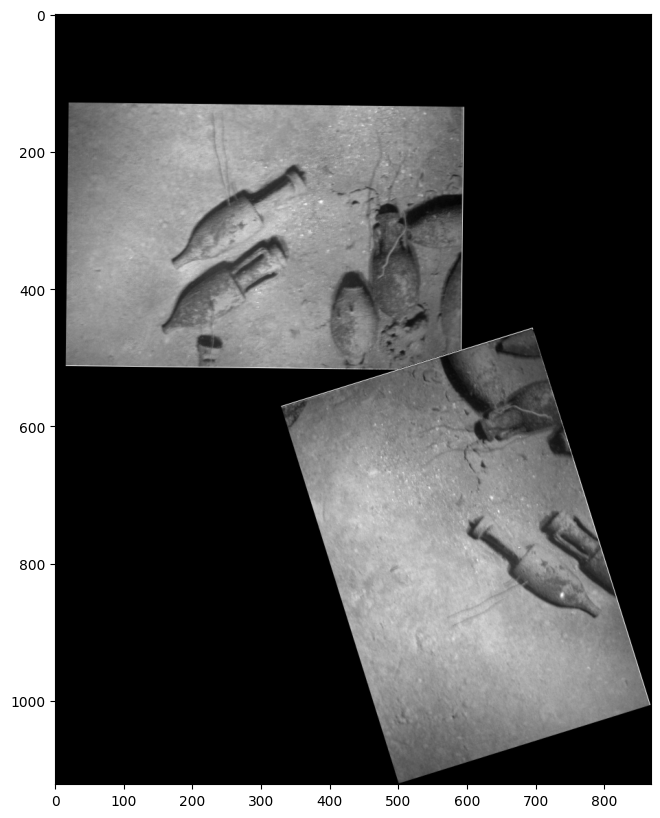

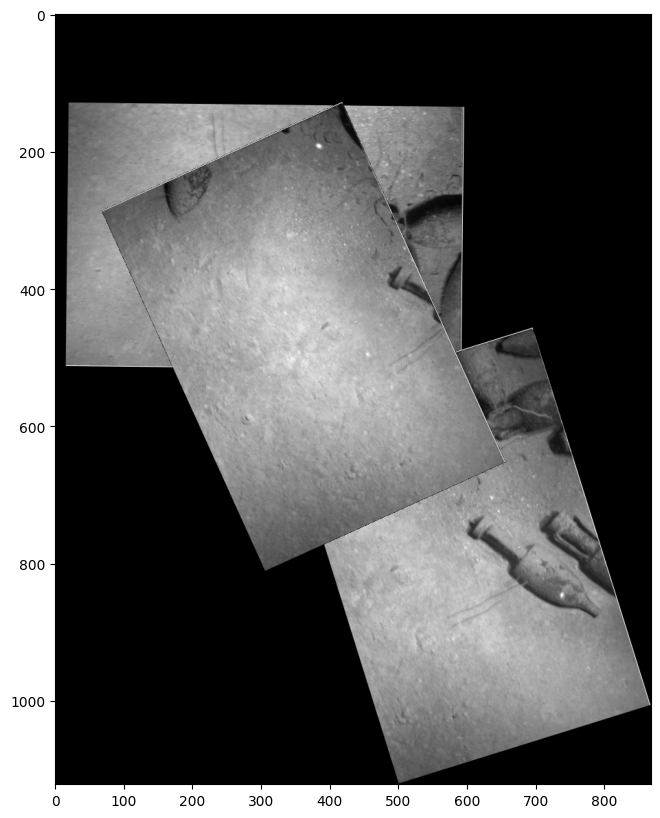

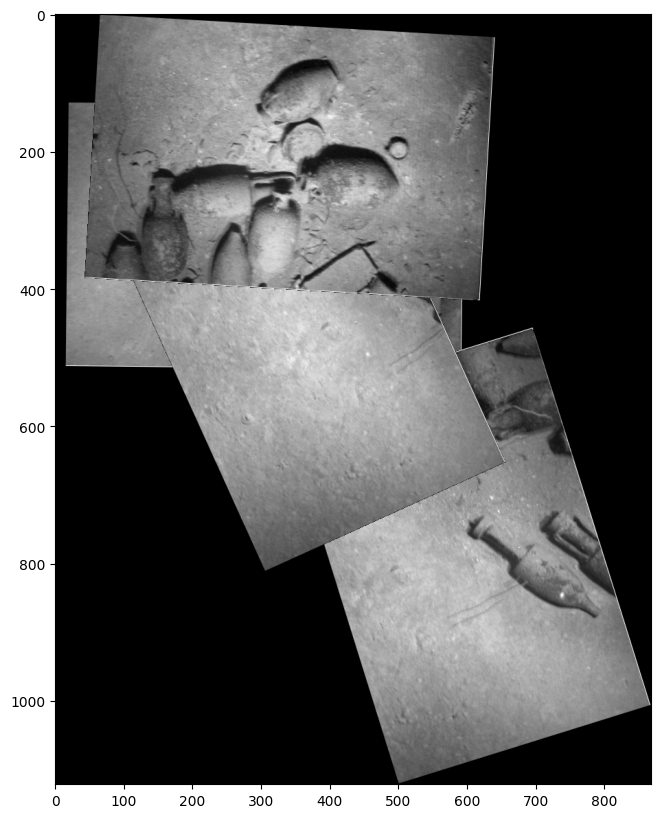

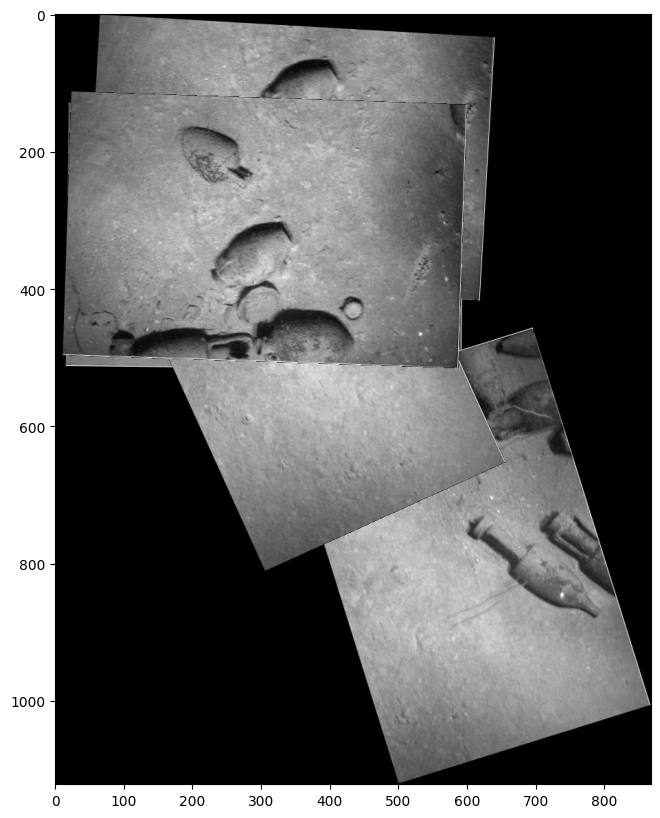

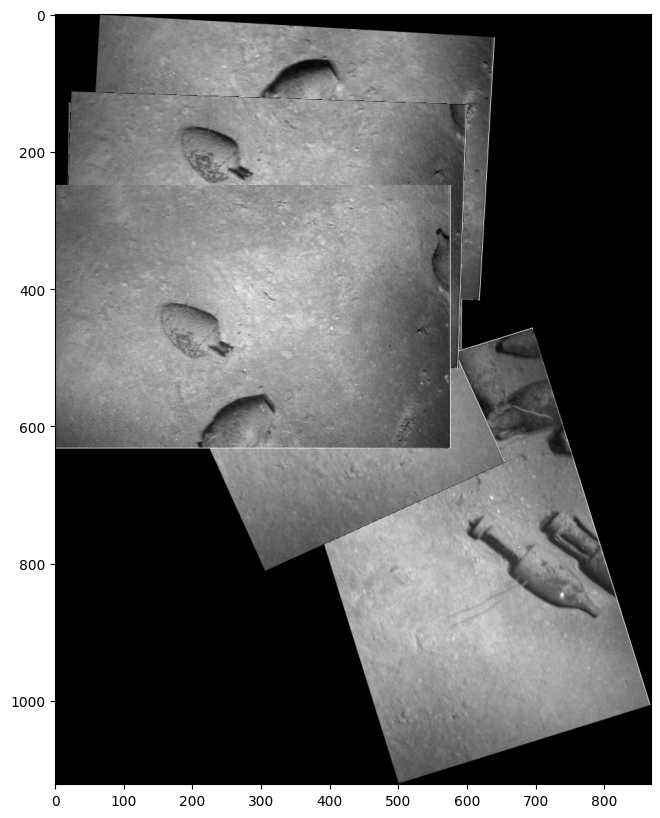

In [438]:
poses = gtsam.utilities.allPose2s(initial_estimate)
affineList = []
AffineOff = np.eye(3, dtype=np.float64)

for i in range(len(NormalizedImages)):
    TranslationMatrix = np.eye(3)
    pose = poses.atPose2(i)
    poseMatrix = pose.matrix()
    TranslationMatrix[:2, 2] -= np.array([im_w / 2, im_h / 2]).T
    affineList.append(poseMatrix.dot(TranslationMatrix))

affineList.reverse()
ImgPoints = [h.dot(np.array([0, 0, 1]).T)[:-1] for h in affineList] + [h.dot(np.array([im_w - 1, 0, 1]).T)[:-1] for h in affineList] + [h.dot(np.array([im_w - 1, im_h - 1, 1]).T)[:-1] for h in affineList] + [h.dot(np.array([0, im_h - 1, 1]).T)[:-1] for h in affineList]
Min = np.floor(np.amin(ImgPoints, axis=0)).astype(np.int32)
Max = np.ceil(np.amax(ImgPoints, axis=0)).astype(np.int32)
Crop = tuple(Max - Min + 1)
AffineOff[0, -1] -= Min[0] if Min[0] < 0 else 0
AffineOff[1, -1] -= Min[1] if Min[1] < 0 else 0
Final = np.zeros((Crop[1], Crop[0], 3), np.uint8)
NormalizedImages.reverse()
for i in range(len(affineList)):
    img = NormalizedImages[i]
    h1 = affineList[i]
    WrappedImage = cv2.warpPerspective(img, AffineOff.dot(h1), Crop)
    Final = np.where(WrappedImage != 0, WrappedImage, Final)
    plt.figure(figsize=(10,10))
    plt.imshow(Final)


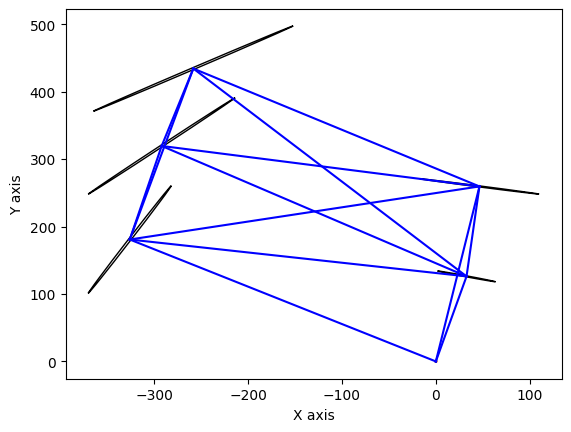

In [439]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)

initial_estimate = optimizer.optimize()
marginals = gtsam.Marginals(graph, initial_estimate)

for i in range(initial_estimate.size()):
    gtsam.utils.plot.plot_pose2(0, initial_estimate.atPose2(i), 0.5, marginals.marginalCovariance(i))

for i in range(graph.size())[1:]:
    k1, k2 = graph.at(i).keys()
    img1Pose = initial_estimate.atPose2(k1)
    img2Pose = initial_estimate.atPose2(k2)
    plt.plot([img1Pose.x(), img2Pose.x()], [img1Pose.y(), img2Pose.y()], color='blue')
plt.show()

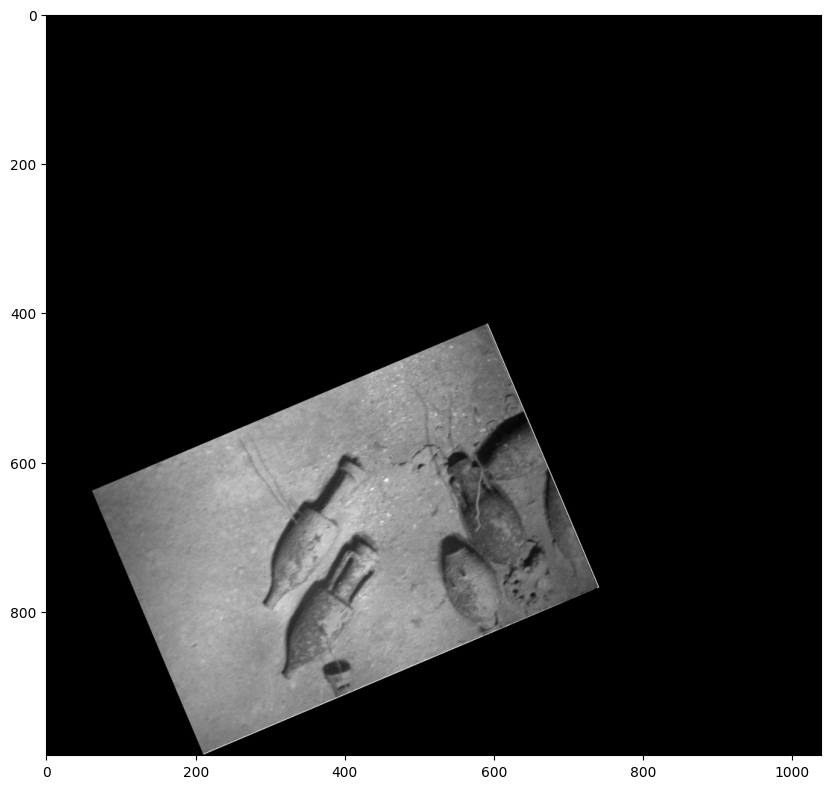

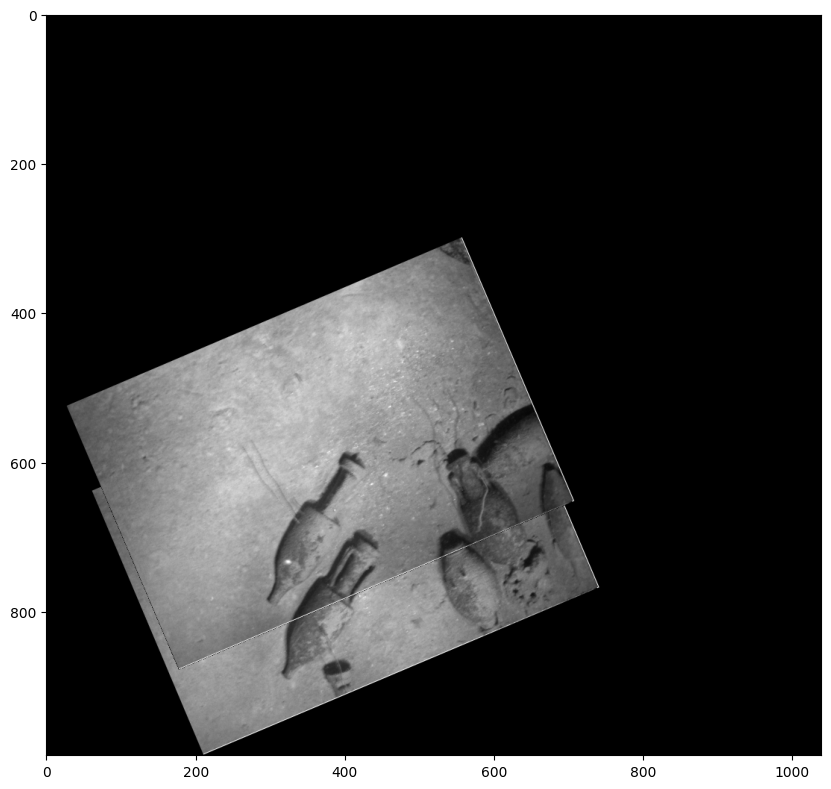

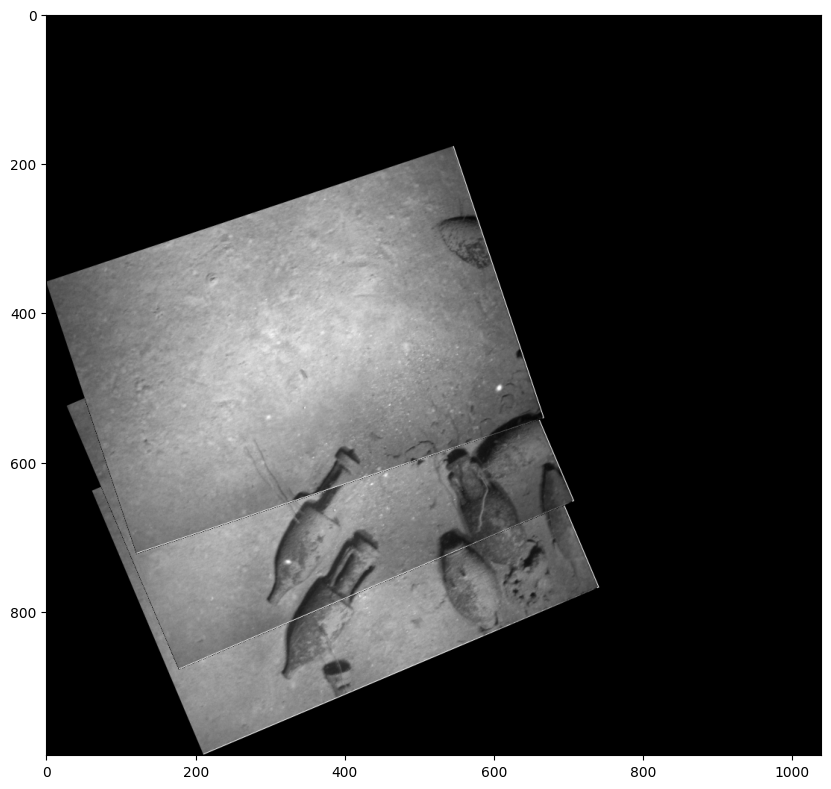

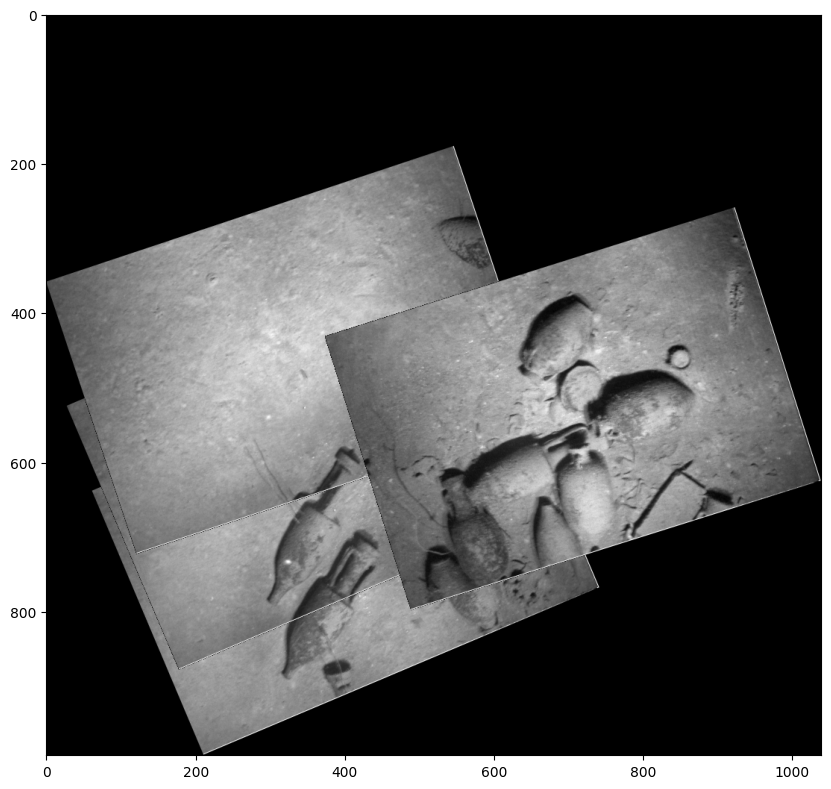

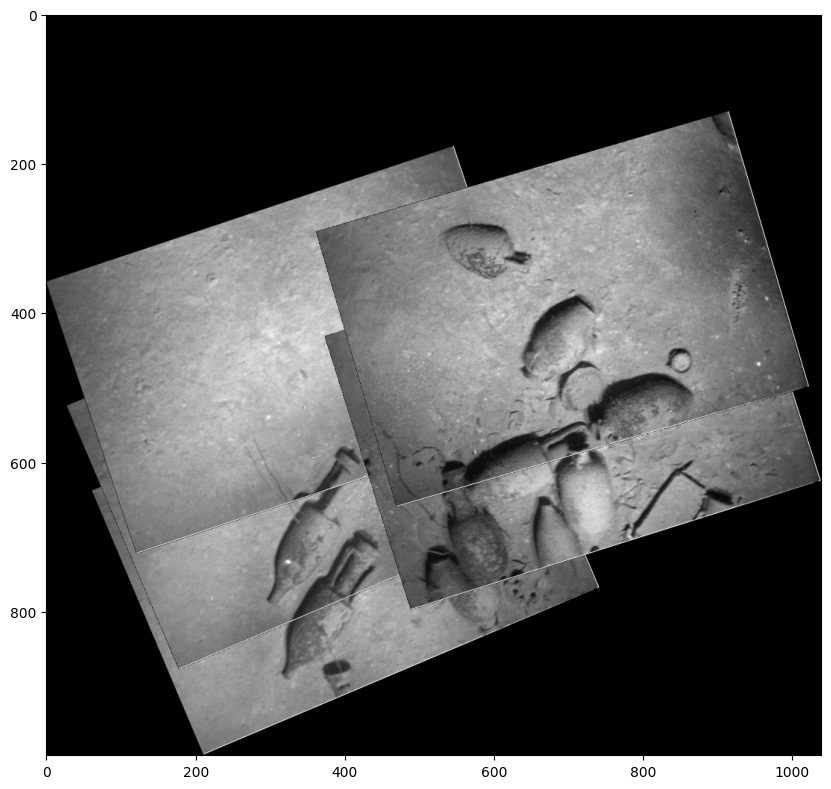

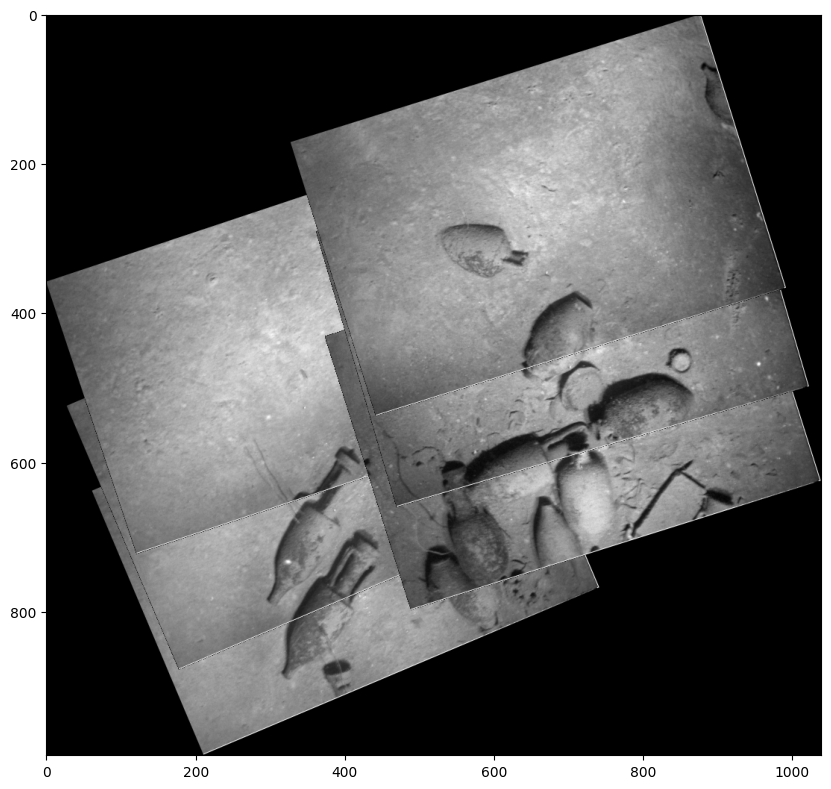

In [440]:
poses = gtsam.utilities.allPose2s(initial_estimate)
affineList = []
AffineOff = np.eye(3, dtype=np.float64)

for i in range(len(NormalizedImages)):
    TranslationMatrix = np.eye(3)
    pose = poses.atPose2(i)
    poseMatrix = pose.matrix()
    TranslationMatrix[:2, 2] -= np.array([im_w / 2, im_h / 2]).T
    affineList.append(poseMatrix.dot(TranslationMatrix))

affineList.reverse()
ImgPoints = [h.dot(np.array([0, 0, 1]).T)[:-1] for h in affineList] + [h.dot(np.array([im_w - 1, 0, 1]).T)[:-1] for h in affineList] + [h.dot(np.array([im_w - 1, im_h - 1, 1]).T)[:-1] for h in affineList] + [h.dot(np.array([0, im_h - 1, 1]).T)[:-1] for h in affineList]
Min = np.floor(np.amin(ImgPoints, axis=0)).astype(np.int32)
Max = np.ceil(np.amax(ImgPoints, axis=0)).astype(np.int32)
Crop = tuple(Max - Min + 1)
AffineOff[0, -1] -= Min[0] if Min[0] < 0 else 0
AffineOff[1, -1] -= Min[1] if Min[1] < 0 else 0
Final = np.zeros((Crop[1], Crop[0], 3), np.uint8)
# NormalizedImages.reverse()
for i in range(len(affineList)):
    img = NormalizedImages[i]
    h1 = affineList[i]
    WrappedImage = cv2.warpPerspective(img, AffineOff.dot(h1), Crop)
    Final = np.where(WrappedImage != 0, WrappedImage, Final)
    plt.figure(figsize=(10,10))
    plt.imshow(Final)
